In [1]:
import glob
import os
from collections import Counter
from itertools import combinations, product

import numpy as np
np.random.seed(18012023)

import pandas as pd
pd.set_option('display.max_colwidth', 0)

from sklearn.metrics import pairwise_distances
import lxml.etree
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from IPython.display import display

In /Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases

## Loading and preprocessing

In [2]:
meta_df = pd.read_excel('../data/metadata_corrected.xlsx')
meta_df = meta_df[meta_df['exclude'] != 'x']
meta_df.sample(10)

,id,title,author,date,provenance,date_range,genre,subgenre,exclude
204,Lutgard K,Sinte Lutgard,NaN,1267.5,CG1,1270-1265,Epiek,Heiligenleven,NaN
63,florigout_fragm_l,Florigout,NaN,1387.5,cdrom-mnl,1375-1400,Epiek,Ridder,NaN
111,loyhier_en_malaert_fragm_a,Loyhier en Malaert,NaN,1375.0,cdrom-mnl,1350-1400,Epiek,Karel,NaN
86,historie_van_gaver_capeel,Historie van Gaver Capeel,NaN,1510.0,cdrom-mnl,1500-1520,Epiek,Ridder,NaN
235,spiegel_historiael__4_velthem__fragm_l,Spiegel historiael (P4 [Velthem]),Lodewijk van Velthem,1350.0,cdrom-mnl,1340-1360,Epiek,Historiografie,NaN
153,ongeidentificeerd_6,Ongeïdentificeerd (6),NaN,1387.5,cdrom-mnl,1375-1400,Epiek,Karel,NaN
211,spiegel_der_sonden,Spiegel der sonden,NaN,1450.0,cdrom-mnl,1440-1460,Epiek,Didactiek,NaN
123,madelgijs_fragm_p,Madelgijs,NaN,1387.5,cdrom-mnl,1375-1400,Epiek,Karel,NaN
167,Reinout van Montalbaen,Reinout van Montalbaen,NaN,1288.0,CG1,1300-1276,Epiek,Karel,NaN
241,tien_plaghen,Tien plaghen ende die tien ghebode,NaN,1400.0,cdrom-mnl,1390-1410,Epiek,Didactiek,NaN


In [3]:
def get_verse_groups(verses, size=2, intertexts=False):
    for i in range(len(verses) - (size)):
        if not intertexts:
            yield ' / '.join(verses[i : i + size])
        else:
            its = Counter(verses[i : i + size])
            if None in its:
                yield None
            elif len(its) > 1:
                yield 'overlap'
            else:
                yield list(its.keys())[0]

In [4]:
GROUP_SIZE = 2

titles, tokens, lemmas, intertexts = [], [], [], []

for title, group in tqdm(meta_df.groupby('title')):
    work_tokens, work_lemmas, work_intertexts = [], [], []
    
    for id_ in sorted(group['id']):
        try:
            tree = lxml.etree.parse(f'../data/xml/{id_}.xml')
        except OSError:
            print(f'- Could not load {id_}')
            continue
        
        # don't remove interpolations?
        #for interpolation in tree.xpath("//interpolation"):
        #    interpolation.getparent().remove(interpolation)
        
        for line_node in tree.iterfind('//l'):
            try:
                intertext_id = line_node.attrib['intertext']
            except KeyError:
                intertext_id = None
            
            tokens_ = line_node.attrib['tokens'].split()
            lemmas_ = []
            
            lemma_tags = [l.text for l in line_node.iterfind('.//lemma')]
            pos_tags = [p.text for p in line_node.iterfind('.//pos')]
            
            for lemma, pos in zip(lemma_tags, pos_tags):
                for l, p in zip(lemma.split('+'), pos.split('+')):
                        if p == 'n(prop)':
                            lemmas_.append('n(prop)')
                        else:
                            lemmas_.append(l)
        
            work_tokens.append(tokens_)
            work_lemmas.append(lemmas_)
            work_intertexts.append(intertext_id)
    
    verse_tokens = [' '.join(v) for v in work_tokens]
    verse_lemmas = [' '.join(v) for v in work_lemmas]

    verse_group_tokens = list(get_verse_groups(verse_tokens, size=GROUP_SIZE))
    verse_group_lemmas = list(get_verse_groups(verse_lemmas, size=GROUP_SIZE))
    verse_group_intertexts = list(get_verse_groups(work_intertexts, size=GROUP_SIZE, intertexts=True))

    tokens.extend(verse_group_tokens)
    lemmas.extend(verse_group_lemmas)
    intertexts.extend(verse_group_intertexts)
    titles.extend([title] * len(verse_group_lemmas))

100%|██████████| 206/206 [17:52<00:00,  5.21s/it]


In [5]:
df = pd.DataFrame(zip(titles, tokens, lemmas, intertexts), columns=('title', 'tokens', 'lemmas', 'intertext'))
df = df[df['intertext'] != 'overlap']
df[(df['title'] == 'Karel ende Elegast') & (~df['intertext'].isna())]

,title,tokens,lemmas,intertext
350351,Karel ende Elegast,Crone draghen ende houden hof / Om te meerderen sinen lof,kroon dragen en houden hof / om te meerderen zijn lof,mor-ele-2
350387,Karel ende Elegast,Als die seere was vereent / Wat ist dat dit wonder meent,als de zeer zijn verenen / wat het zijn dat dit wonder menen,lan-ele-47
350399,Karel ende Elegast,Mijn lant is so groot / Men vint nyewers sijns ghenoot,mijn land zijn zo groot / men vinden nieuwer zijn genoot,mor-ele-5
350438,Karel ende Elegast,En wil ic niet laten achter / Ic sel dief wesen al ist lachter,ne willen ik niet laten achter / ik zullen dief wezen al zijn het lachter,mor-ele-8
350466,Karel ende Elegast,Moet varen in een lant / Dat mi is vremde ende onbecant,moeten varen in een land / dat ik zijn vreemd en onbekend,mor-ele-10
350468,Karel ende Elegast,Mit deser talen ghinc hem gereyden / Die coninc karel ende cleyden,met deze taal gaan hij gereden / de koning n(prop) en kleden,mor-ele-11
350541,Karel ende Elegast,Dieue te hatene daer icse wiste / Die den lieden mit liste,dief te haten daar ik zij weten / die de lieden met list,mor-ele-15
350565,Karel ende Elegast,Beide borch ende lant / Des was ic herde onbekant,beide burg en land / dat zijn ik harden onbekend,mor-ele-16
350631,Karel ende Elegast,Nochtan weet ic te voren wel / Tis die duuel ende niemant el,nochtan weten ik te voren wel / het is de duivel en niemand el,mor-ele-17
350645,Karel ende Elegast,Pensde hi in sinen sin / Dese is verdoelt hier in,peinzen hij in zijn zin / deze zijn verdolen hier in,mor-ele-19


In [6]:
vec = TfidfVectorizer(max_features=10000, min_df=2, token_pattern=r"(?u)\b\w+\b")
X = vec.fit_transform(df['lemmas'])
X.shape

(924823, 10000)

In [7]:
rhyme_words = []
for lemmas in df['lemmas']:
    rhymes = []
    for verse in lemmas.split(' / '):
        rhymes.append(verse.strip().split()[-1])
    rhyme_words.append(' '.join(rhymes))
df['rhyme'] = rhyme_words

df[(df['title'] == 'Karel ende Elegast') & (~df['intertext'].isna())]

,title,tokens,lemmas,intertext,rhyme
350351,Karel ende Elegast,Crone draghen ende houden hof / Om te meerderen sinen lof,kroon dragen en houden hof / om te meerderen zijn lof,mor-ele-2,hof lof
350387,Karel ende Elegast,Als die seere was vereent / Wat ist dat dit wonder meent,als de zeer zijn verenen / wat het zijn dat dit wonder menen,lan-ele-47,verenen menen
350399,Karel ende Elegast,Mijn lant is so groot / Men vint nyewers sijns ghenoot,mijn land zijn zo groot / men vinden nieuwer zijn genoot,mor-ele-5,groot genoot
350438,Karel ende Elegast,En wil ic niet laten achter / Ic sel dief wesen al ist lachter,ne willen ik niet laten achter / ik zullen dief wezen al zijn het lachter,mor-ele-8,achter lachter
350466,Karel ende Elegast,Moet varen in een lant / Dat mi is vremde ende onbecant,moeten varen in een land / dat ik zijn vreemd en onbekend,mor-ele-10,land onbekend
350468,Karel ende Elegast,Mit deser talen ghinc hem gereyden / Die coninc karel ende cleyden,met deze taal gaan hij gereden / de koning n(prop) en kleden,mor-ele-11,gereden kleden
350541,Karel ende Elegast,Dieue te hatene daer icse wiste / Die den lieden mit liste,dief te haten daar ik zij weten / die de lieden met list,mor-ele-15,weten list
350565,Karel ende Elegast,Beide borch ende lant / Des was ic herde onbekant,beide burg en land / dat zijn ik harden onbekend,mor-ele-16,land onbekend
350631,Karel ende Elegast,Nochtan weet ic te voren wel / Tis die duuel ende niemant el,nochtan weten ik te voren wel / het is de duivel en niemand el,mor-ele-17,wel el
350645,Karel ende Elegast,Pensde hi in sinen sin / Dese is verdoelt hier in,peinzen hij in zijn zin / deze zijn verdolen hier in,mor-ele-19,zin in


## Nearest neighbors

In [8]:
def nearest_verses(title1, title2, base_df, vectorizer, prop_filt=2, rhyme_weight=.25):
    A = base_df[base_df['title'] == title1]
    B = base_df[base_df['title'] == title2]
    
    AX = vec.transform(A['lemmas']) + rhyme_weight * vec.transform(A['rhyme'])
    BX = vec.transform(B['lemmas']) + rhyme_weight * vec.transform(B['rhyme'])
    
    nearest = []
    for i, ax in enumerate(AX):
        distances = pairwise_distances(ax, BX, metric='cosine').flatten()
        top_i = distances.argsort()[0]
        nearest.append((A.iloc[i]['tokens'], B.iloc[top_i]['tokens'],
                        A.iloc[i]['lemmas'], B.iloc[top_i]['lemmas'],
                        A.iloc[i]['title'], B.iloc[top_i]['title'],
                        A.iloc[i]['intertext'], B.iloc[top_i]['intertext'],
                        distances[top_i]))

    nearest = pd.DataFrame(nearest,
                           columns=['tokens1', 'tokens2', 'lemmas1', 'lemmas2',
                                    'title1', 'title2', 'intertext1', 'intertext2',
                                    'distance'])

    nearest = nearest[nearest['title1'] != nearest['title2']]
    nearest = nearest[
                      (nearest['lemmas1'].str.count('n\(prop\)') < prop_filt) & \
                      (nearest['lemmas1'].str.count('n\(prop\)') < prop_filt) 
                     ]
    return nearest

In [9]:
nearest_df = nearest_verses('Moriaen', 'Karel ende Elegast',
                            base_df=df, vectorizer=vec, prop_filt=2)
nearest_df = nearest_df.sort_values(by='distance')
nearest_df.head(50)

,tokens1,tokens2,lemmas1,lemmas2,title1,title2,intertext1,intertext2,distance
163,Nu es leden die derde dach / Dat ic voer om min bejach,Dies is leden die derde dach / Dat ic voer om mijn beiach,nu zijn lijden de derde dag / dat ik varen om mijn bejag,die zijn lijden de derde dag / dat ik varen om mijn bejag,Moriaen,Karel ende Elegast,mor-ele-44,mor-ele-44,0.032437
2909,Ende segt mi ende maect mi vroet / Wat noetsaken dat u doet,In dien dat ghi mi maket vroet / Wat nootsaken dat v doet,en zeggen ik en maken ik vroed / wat noodzaak dat gij doen,in die dat gij ik maken vroed / wat noodzaak dat uw doen,Moriaen,Karel ende Elegast,mor-ele-31,mor-ele-31,0.113156
193,Want ic come u te genaden / Van allen minen mesdaden,Ic come v heden te ghenaden / Van allen minen misdaden,want ik komen gij te genade / van al mijn misdaad,ik komen gij heden te genade / van al mijn misdaad,Moriaen,Karel ende Elegast,mor-ele-72,mor-ele-72,0.119965
1288,Men doet mi lachter onverdient / Quame enech Gods vrient,Dadi mi lachter onuerdient / Ghi hadt verloren menigen vrient,men doen ik lachter onverdiend / komen enig god vriend,doen ik lachter onverdiend / gij hebben verliezen menig vriend,Moriaen,Karel ende Elegast,None,None,0.180574
1839,Die grote ondaet ende die mort / Hi sprac te sinen lieden vort,Dat ghi segt ende brenct voort / Die ondaet ende die moort,de groot ondaad en de moord / hij spreken te zijn lieden voort,dat gij zeggen en brengen voort / de ondaad en de moord,Moriaen,Karel ende Elegast,mor-ele-70,mor-ele-70,0.184378
447,Dan mi een ridder dwingen soude / Van dies ic doen nine woude,Dat mi een man dwinghen soude / Van dinghen die ic niet en woude,dan ik een ridder dwingen zullen / van die ik doen ne niet willen,dat ik een man dwingen zullen / van ding die ik niet ne willen,Moriaen,Karel ende Elegast,mor-ele-22,mor-ele-22,0.195125
893,U ne gesciets niet te wors / Her Walewein sat doe op sijn ors,Al souts mi sijn te wors / Nv sit weder op v ors,gij ne geschieden niet te waars / heer n(prop) zitten toen op zijn hors,al zullen ik zijn te waars / nu zitten weer op uw hors,Moriaen,Karel ende Elegast,mor-ele-78,mor-ele-78,0.204850
877,Maer wistic uwer beider name / Ende u wille ware ende bequame,Ick sel v segghen minen name / Ist v wille ende bequame,maar ik weten uw beide naam / en uw wil zijn en bekwaam,ik zullen gij zeggen mijn naam / zijn het uw wil en bekwaam,Moriaen,Karel ende Elegast,mor-ele-38,mor-ele-38,0.205585
2949,Si hadden daer soe grote macht / Ende vingen Arture met harre cracht,Eggeric was van groter macht / Ende alle die hadden cracht,zij hebben daar zo groot macht / en vangen n(prop) met haar kracht,n(prop) zijn van groot macht / en al die hebben kracht,Moriaen,Karel ende Elegast,None,None,0.229380
3763,Doe pensdi in sinen moet / Op dattie trappen waren so goet,Pensde hi in sinen moet / Dat ick leue waer toe ist goet,toen hij peinzen in zijn moed / op dat de n(prop) zijn zo goed,peinzen hij in zijn moed / dat ik leven zijn toe zijn het goed,Moriaen,Karel ende Elegast,None,None,0.233530


In [10]:
meta = pd.read_excel('../data/intertexts.xlsx')
meta

,ID,source,src-passage,target,trg-passage,verse-length,biblio,remarks,Unnamed: 8
0,mor-ele-1,Moriaen,Dat magic v nv tellen,Karel ende Elegast,Mach ic v tellen,1,"Heeroma 1973a, Moriaen (I)",NaN,NaN
1,mor-ele-2,Moriaen,hilt hof Om te merre sinen lof.,Karel ende Elegast,houden hof Omme te meerne sinen lof:,2,"Heeroma 1973a, Moriaen (I)",NaN,NaN
2,mor-ele-3,Moriaen,Hastelike ende nine spard.,Karel ende Elegast,Haestelic ende niet en spaert:,1,"Heeroma 1973a, Moriaen (I)",NaN,NaN
3,mor-ele-4,Moriaen,Nv nes niweren in ertrike.,Karel ende Elegast,En es man in aertrijcke:,1,"Heeroma 1973a, Moriaen (I)",NaN,NaN
4,mor-ele-5,Moriaen,sine macht (es) so groet Ic waen men nigeren sine genoet Ne soude vinden.,Karel ende Elegast,Mijns selfs lant es soe groot Men vint nyewers sijns ghenoot:,3,"Heeroma 1973a, Moriaen (I)",NaN,NaN
...,...,...,...,...,...,...,...,...,...
224,mor-ele-40,Lantsloot van der Haghedochte,Ende droegen des ouer een:,Moriaen,Ende drogen des daer ouer een.,1,NaN,Nestedness!,NaN
225,mor-ele-61,Lantsloot van der Haghedochte,Dien hi harde lange voer Ende vernam van niemene boer:,Moriaen,Daer men met scepen ouer voer Ende daer verlosic al dat boer.,2,NaN,NaN,NaN
226,lan-ele-74,Lantsloot van der Haghedochte,Ende sijn ors toe gemake gedaen:,Moriaen,Sijn ors was te gemake gedaen.,1,NaN,NaN,NaN
227,lan-ele-75,Lantsloot van der Haghedochte,Doe die dienst was gedaen:,Moriaen,Doe die dinst was gedaen.,1,NaN,NaN,NaN


## Precision-recall paradigm

In [11]:
from sklearn.metrics import f1_score, precision_score, recall_score, fbeta_score

In [12]:
def precision_recall(df, meta, rhyme_weight=.25):
    titles = set(list(meta['source']) + list(meta['target']))
    relevances, distances = [], []

    for t1, t2 in product(titles, titles):
        if t1 == t2:
            continue
        print(t1, t2)

        m = meta[meta['verse-length'] >= 2]
        m = m[(m['source'] == t1) | (m['source'] == t2)]
        m = m[(m['target'] == t1) | (m['target'] == t2)]

        if not len(m):
            continue

        A = df[(~df['intertext'].isna()) & (df['title'] == t1)]
        B = df[df['title'] == t2]

        AX = vec.transform(A['lemmas']) + rhyme_weight * vec.transform(A['rhyme'])
        BX = vec.transform(B['lemmas']) + rhyme_weight * vec.transform(B['rhyme'])

        all_distances = pairwise_distances(AX, BX, metric='cosine')

        for a_idx, (_, a) in enumerate(A.iterrows()):
            distances.extend(all_distances[a_idx])
            relevances.extend((B['intertext'] == a['intertext']).astype(int))
    
    return relevances, distances

In [13]:
relevances, distances = precision_recall(df, meta)

Karel ende Elegast Riddere metter mouwen
Karel ende Elegast Moriaen
Karel ende Elegast Lantsloot van der Haghedochte
Riddere metter mouwen Karel ende Elegast
Riddere metter mouwen Moriaen
Riddere metter mouwen Lantsloot van der Haghedochte
Moriaen Karel ende Elegast
Moriaen Riddere metter mouwen
Moriaen Lantsloot van der Haghedochte
Lantsloot van der Haghedochte Karel ende Elegast
Lantsloot van der Haghedochte Riddere metter mouwen
Lantsloot van der Haghedochte Moriaen


Use complement of the cosine distance as a pseudo-probability:

In [14]:
distances = 1 - np.array(distances)

(0.0, 1.0)

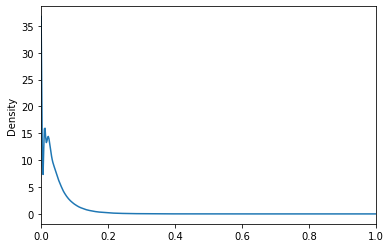

In [15]:
pd.Series(distances).plot.kde()
plt.xlim((0, 1))

In [16]:
scores = []
for th in np.linspace(0.01, 1.01, 100):
    labels_ = (distances >= th) * 1
    scores.append((th,
                   f1_score(relevances, labels_),
                   fbeta_score(relevances, labels_, beta=0.75), # beta as legacy parameter
                   precision_score(relevances, labels_),
                   recall_score(relevances, labels_)))
thresholds, f1s, fbetas, precisions, recalls = zip(*scores)

/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
max_f1_idx = np.array(f1s).argmax()
max_f1 = f1s[max_f1_idx]
max_f1_th = thresholds[max_f1_idx]
print(f'Dev results -> F1={max_f1} at th={max_f1_th}')

Dev results -> F1=0.35328753680078506 at th=0.5958585858585859


In [18]:
max_fb_idx = np.array(fbetas).argmax()
max_fb = f1s[max_fb_idx]
max_fb_th = thresholds[max_fb_idx]
print(f'Dev results -> Fbeta={max_fb} at th={max_fb_th}')

Dev results -> Fbeta=0.34946871310507677 at th=0.6463636363636365


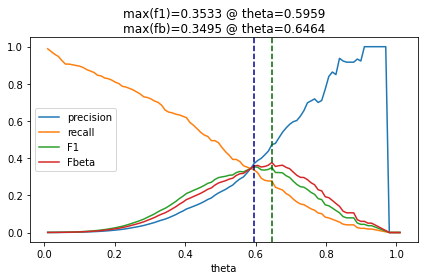

In [19]:
plt.plot(thresholds, precisions, label='precision')
plt.plot(thresholds, recalls, label='recall')
plt.plot(thresholds, f1s, label='F1')
plt.plot(thresholds, fbetas, label='Fbeta')
plt.axvline(max_f1_th, ls='--', c='darkblue')
plt.axvline(max_fb_th, ls='--', c='darkgreen')
plt.gca().set_xlabel('theta')
plt.gca().legend()
plt.title(f'max(f1)={round(max_f1, 4)} @ theta={round(max_f1_th, 4)}\n' +\
          f'max(fb)={round(max_fb, 4)} @ theta={round(max_fb_th, 4)}')
plt.tight_layout()

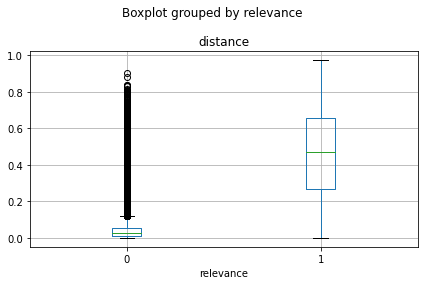

In [20]:
res_df = pd.DataFrame(zip(distances, relevances), columns=('distance', 'relevance'))
res_df.boxplot('distance', 'relevance')
plt.tight_layout();

In [21]:
def top_dist(title1, title2, base_df, meta, vectorizer,
          length_threshold=2, rhyme_weight=.25, dist_threshold=10):
    meta = meta[meta['verse-length'] >= length_threshold]
    meta = meta[(meta['source'] == title1) | (meta['source'] == title2)]
    meta = meta[(meta['target'] == title1) | (meta['target'] == title2)]
    
    if not len(meta):
        return None
    
    A = base_df[(base_df['title'] == title1) & (base_df['intertext'].isin(meta['ID']))]
    B = base_df[base_df['title'] == title2]
    
    AX = vectorizer.transform(A['lemmas']) + rhyme_weight * vec.transform(A['rhyme'])
    BX = vectorizer.transform(B['lemmas']) + rhyme_weight * vec.transform(B['rhyme'])
    
    hits_in_k, results, retrieved = 0, [], []
    
    for (_, a), ax in zip(A.iterrows(), AX):
        distances = pairwise_distances(ax, BX, metric='cosine').flatten()
        top_k = distances <= dist_threshold
        candidates = B.iloc[top_k].copy()
        candidates['distance'] = distances[top_k]
        candidates['category'] = 'hit'
        
        if a['intertext'] in set(candidates['intertext']):
            hits_in_k += 1
            retrieved.append(True)
        else:
            retrieved.append(False)

        a['distance'] = 0.0
        a['category'] = 'query'
        
        candidates.loc[len(candidates)] = a
        results.append(candidates.sort_values('distance'))

    return {'num_hits': hits_in_k,
            'num_queries': len(A),
            'coverage': hits_in_k / len(A),
            'retrieval': retrieved,
            'ranking': results}

## Average precision

In [22]:
from sklearn.metrics import label_ranking_average_precision_score

def average_precision(df, meta, rhyme_weight=.25, length_threshold=2):
    titles = set(list(meta['source']) + list(meta['target']))
    scores = []

    for t1, t2 in product(titles, titles):
        if t1 == t2:
            continue

        m = meta[meta['verse-length'] >= length_threshold]
        m = m[(m['source'] == t1) | (m['source'] == t2)]
        m = m[(m['target'] == t1) | (m['target'] == t2)]

        if not len(m):
            continue

        A = df[(~df['intertext'].isna()) & (df['title'] == t1)]
        B = df[df['title'] == t2]

        AX = vec.transform(A['lemmas']) + rhyme_weight * vec.transform(A['rhyme'])
        BX = vec.transform(B['lemmas']) + rhyme_weight * vec.transform(B['rhyme'])

        all_distances = pairwise_distances(AX, BX, metric='cosine')
        
        relevances, distances = [], []
        
        for a_idx, (_, a) in enumerate(A.iterrows()):
            distances.append(all_distances[a_idx])
            relevances.append((B['intertext'] == a['intertext']).astype(int))
            
        relevances, distances = np.array(relevances), np.array(distances)
        score = label_ranking_average_precision_score(relevances, distances)
        scores.append(score)
    
    return scores

In [23]:
scores = []

thresholds = np.linspace(0, 1, 10)

for th in thresholds:
    scores.append(average_precision(df, meta, rhyme_weight=th))

scores

[[0.20019053724970534,
  0.6546310212514046,
  0.00026852790588189815,
  0.6353189475142809,
  0.8321693596179165,
  0.4162152998634979,
  0.7099293302703157,
  0.09706337087045074],
 [0.20019004856887415,
  0.6546310114754145,
  0.00026787952910701124,
  0.6353182294166217,
  0.8321689925363135,
  0.41621533929888044,
  0.7099288825898667,
  0.09706506754569035],
 [0.2001899997813438,
  0.6546311722100786,
  0.0002676600995057616,
  0.6353180741072585,
  0.832168735336548,
  0.4162154597770516,
  0.709928706123454,
  0.09706599459070293],
 [0.20019005975932372,
  0.6546313277787125,
  0.000267611726588482,
  0.635318074252503,
  0.832168632794519,
  0.4162155584862992,
  0.7099289878106227,
  0.09706642037271505],
 [0.2001901262492209,
  0.6546314074360622,
  0.0002675407268904764,
  0.6353181081741373,
  0.8321685664875951,
  0.41621564151368845,
  0.7099290689022821,
  0.09706677595203209],
 [0.20019018781809905,
  0.6546314684551079,
  0.0002675965804008624,
  0.6353182953921996,
 

In [24]:
scores = pd.DataFrame(np.array(scores), index=thresholds)

<AxesSubplot:>

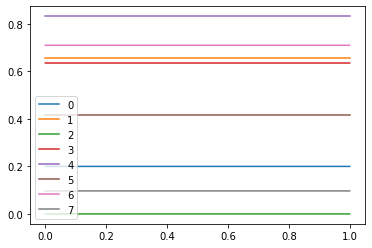

In [25]:
scores.plot()

## Case studies

#### Well-known cases of intertextual borrowing

In [26]:
def distance_nn(title1, title2, rhyme_weight=.25, batch_size=5000):
    
    def batch(iterable, n=1):
        l = iterable.shape[0]
        for ndx in range(0, l, n):
            yield iterable[ndx:min(ndx + n, l)]
    
    A = df[df['title'] == title1]
    B = df[df['title'] == title2]

    AX = vec.transform(A['lemmas']) + rhyme_weight * vec.transform(A['rhyme'])
    BX = vec.transform(B['lemmas']) + rhyme_weight * vec.transform(B['rhyme'])

    all_distances = []

    for ax in batch(AX, batch_size):
         all_distances.extend(pairwise_distances(ax, BX, metric='cosine').min(axis=1))
    
    return pd.Series(all_distances)

def plot_min_distance_nn(t1, t2, min_dists, threshold, rolling_size=1000):
    mu = min_dists.rolling(rolling_size).mean()
    fig, ax = plt.subplots()
    mu.plot(ax=ax)
    ax.axhline(threshold, ls='--', c='grey')
    ax.set_ylim(0, 1)
    ax.set_xlabel(t1)
    ax.set_ylabel('Distance to NN in ' + t2)
    return ax

In [27]:
rolling_size, threshold = 1000, 1 - 0.59
print(threshold)

0.41000000000000003


Heelu in de Vijfde Partie:

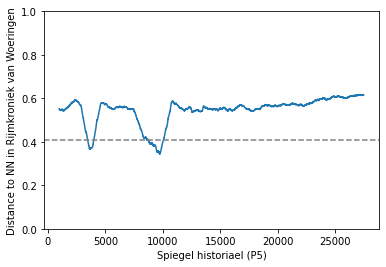

In [28]:
t1, t2 = 'Spiegel historiael (P5)', 'Rijmkroniek van Woeringen'
min_dists = distance_nn(t1, t2)
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=threshold, rolling_size=1000);

Maerlant in de Brabantse yeesten:

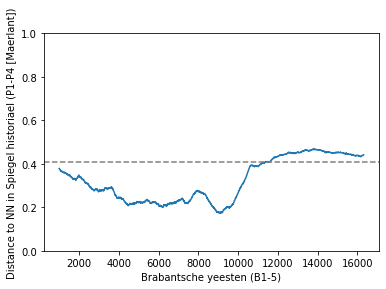

In [29]:
t1, t2 = 'Brabantsche yeesten (B1-5)', 'Spiegel historiael (P1-P4 [Maerlant])'
min_dists = distance_nn(t1, t2)
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=threshold, rolling_size=1000);

Walewein-passage in Moriaen:

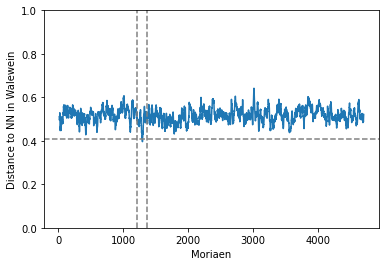

In [30]:
t1, t2 = 'Moriaen', 'Walewein'
min_dists = distance_nn(t1, t2)
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=threshold, rolling_size=20);
ax.axvline(1215, c='grey', ls='--')
ax.axvline(1365, c='grey', ls='--');

#### Large-scale detection

In [31]:
#chiv_titles = meta_df[meta_df['subgenre'].isin(('Arthur', 'Ridder', 'Karel', 'Kruisvaart', 'Dier'))]['title'].unique()
chiv_titles = meta_df[meta_df['genre'] == 'Epiek']['title'].unique()
chiv_titles

array(['Alexanders geesten', 'Alexiuslegende', 'Anatomie van de mens',
       'Arturs doet', 'Aubri de Borgengoen', 'Barlaam en Josaphat',
       'Beatrijs', 'Bediedenisse van der missen',
       'Beerte metten breden voeten', 'Beginsel der oorlogen van Luyck',
       'Boec Exemplaer', 'Boec van den houte', 'Boec vander wraken',
       'Boeve van Hamtone', 'Borchgrave van Couchi',
       'Borchgravinne van Vergi (1)', 'Borchgravinne van Vergi (2)',
       'Boudewijn van Seborch', 'Brabantsche yeesten (B1-5)',
       'Brabantsche yeesten (B6)', 'Brabantsche yeesten (B7)',
       'Nevelingenlied', "Chanson d'Aspremont", 'Collectief lunarium I',
       'Collectief lunarium III', 'Commentaar op het Hooglied',
       'Collectief lunarium II', 'Cyromanchie van den pape van den Hamme',
       'Der leken spieghel', 'Der mannen ende vrouwen heimelijcheit',
       'Der minnen loep', 'Der naturen bloeme',
       'Der vrouwen heimelijcheit', 'Der ystorien bloeme',
       'Dietsche doctrinale', 'Di

In [36]:
results = []
for t1, t2 in tqdm(list(product(chiv_titles, chiv_titles))):
    if t1 == t2:
        continue
    results.append((t1, t2, distance_nn(t1, t2, batch_size=10000)))

 36%|███▋      | 9578/26244 [1:30:28<2:37:26,  1.76it/s] 


KeyboardInterrupt: 

In [37]:
results = pd.DataFrame(results, columns=('t1', 't2', 'nn'))
results

,t1,t2,nn
0,Alexanders geesten,Alexiuslegende,"0 0.617699 1 0.780955 2 0.898295 3 0.797670 4 0.683940 ... 14211 0.768449 14212 0.739743 14213 0.822237 14214 0.834267 14215 0.830800 Length: 14216, dtype: float64"
1,Alexanders geesten,Anatomie van de mens,"0 0.729162 1 0.733231 2 0.805213 3 0.839715 4 0.815749 ... 14211 0.758708 14212 0.611584 14213 0.702226 14214 0.776507 14215 0.765161 Length: 14216, dtype: float64"
2,Alexanders geesten,Arturs doet,"0 0.558535 1 0.598724 2 0.710102 3 0.708670 4 0.597345 ... 14211 0.701451 14212 0.530235 14213 0.591259 14214 0.596018 14215 0.520695 Length: 14216, dtype: float64"
3,Alexanders geesten,Aubri de Borgengoen,"0 0.750233 1 0.685684 2 0.828447 3 0.846661 4 0.713792 ... 14211 0.807979 14212 0.740795 14213 0.792367 14214 0.772406 14215 0.593182 Length: 14216, dtype: float64"
4,Alexanders geesten,Barlaam en Josaphat,"0 0.733045 1 0.775633 2 0.844637 3 0.845999 4 0.713241 ... 14211 0.708125 14212 0.655190 14213 0.826530 14214 0.769738 14215 0.745271 Length: 14216, dtype: float64"
...,...,...,...
9514,Historie van Troyen,Borchgravinne van Vergi (1),"0 0.543921 1 0.568810 2 0.795488 3 0.692624 4 0.656644 ... 40859 0.693729 40860 0.797059 40861 0.775468 40862 0.673408 40863 0.684610 Length: 40864, dtype: float64"
9515,Historie van Troyen,Borchgravinne van Vergi (2),"0 0.481502 1 0.518986 2 0.845768 3 0.779020 4 0.665477 ... 40859 0.824397 40860 0.859911 40861 0.853393 40862 0.810812 40863 0.729165 Length: 40864, dtype: float64"
9516,Historie van Troyen,Boudewijn van Seborch,"0 0.734039 1 0.752277 2 0.776081 3 0.716110 4 0.779722 ... 40859 0.829477 40860 0.852910 40861 0.801647 40862 0.679459 40863 0.591145 Length: 40864, dtype: float64"
9517,Historie van Troyen,Brabantsche yeesten (B1-5),"0 0.697343 1 0.702800 2 0.662083 3 0.497803 4 0.457141 ... 40859 0.396762 40860 0.450584 40861 0.440702 40862 0.474328 40863 0.452092 Length: 40864, dtype: float64"


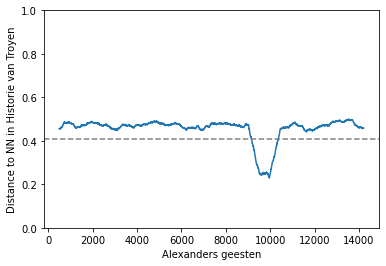

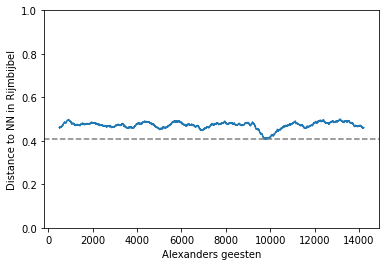

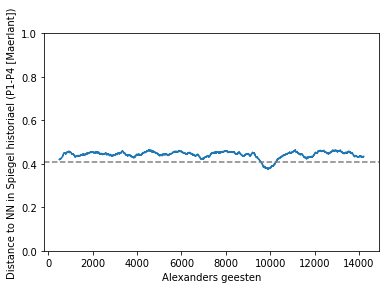

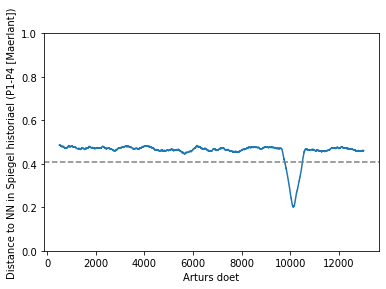

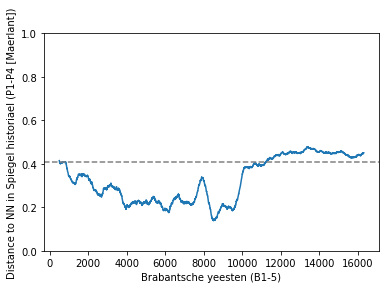

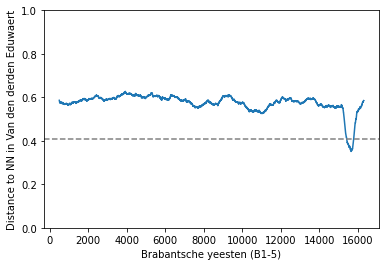

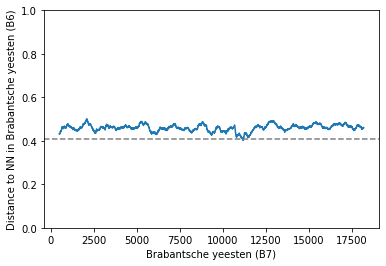

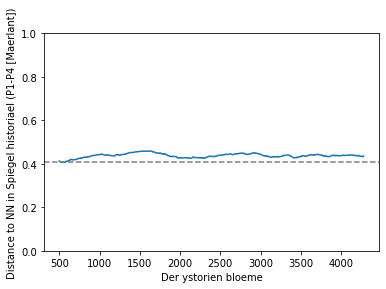

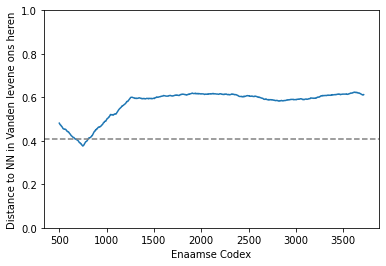

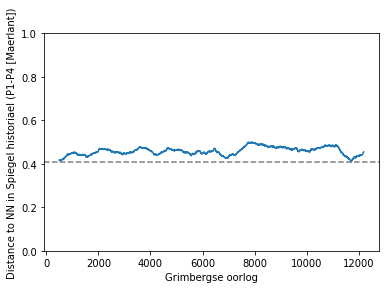

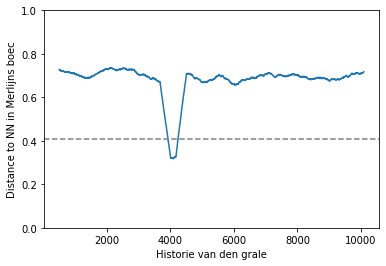

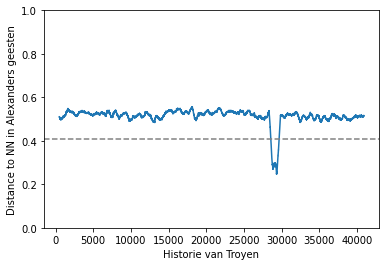

In [46]:
rolling_size = 500
for _, r in results.iterrows():
    if np.any(r['nn'].rolling(rolling_size).mean() < threshold):
        plot_min_distance_nn(r['t1'], r['t2'], r['nn'],
                         threshold=threshold, rolling_size=rolling_size);

## 